In [2]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import yfinance as yf

from arch.compat.numba import jit

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

from enum import Enum
import math

In [3]:
class BetaType(Enum):
    NO = 1
    RAW = 2
    RETURNS = 3
    FILTERED = 4

In [4]:
DATE_FROM = '2015-01-01'
DATE_TO = '2017-12-31'
tickers = ['TSLA', 'AAPL', 'IBM', 'AMZN', 'MMM',
           'ABMD', 'ACN', 'APD', 'GOOGL', 'BLK']

INITIAL_CASH = 500000
FEE = 0.001
MAX_POSITION_PER_EQUITY = max(1. / len(tickers), 0.2)
MAX_POSITION_PER_EQUITY_PER_TRADE = max(1. / len(tickers), 0.05)
MAX_DRAWDOWN_PER_DAY = 0.005
MAX_DRAWDOWN_PER_WEEK = 0.02

In [5]:
BETA_TYPE = BetaType.FILTERED
BETA_LAG = 252
GARCH_LAG = 200
CORRELATION_MATRIX_LAG = 200
GARCH_REFIT_DELAY_DAYS = 30

In [6]:
MEAN_MODEL = "Constant"
VOL_MODEL = "Garch"
DISTRIBUTION_ = "Normal"

In [7]:
p_ = 2
o_ = 0
q_ = 2

In [8]:

def _find_best_model_params(TS: pd.Series):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(1, 5) # [1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(method='mle', trend='nc')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order

In [9]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [10]:
def raw_adj_close_prices(ticker: str, date_from: str, date_to: str):
    prices = yf.download(ticker, date_from, date_to)
    prices.index = prices.index.to_period(freq='d')
    return prices['Adj Close']

In [11]:
def raw_adj_close_log_returns(prices: pd.Series):
    return np.log(prices).diff().fillna(0)

In [12]:
def beta(market: pd.Series, single_stock: pd.Series, lag: int = 252):
    return market.cov(single_stock, lag) / market.std(ddof=lag)

In [13]:
@jit
def arch_filtered_series(returns: pd.Series,
                         dist: str = 'Normal',
                         mean: str = 'HARX',
                         vol: str = 'Garch',
                         lag: int = 200,
                         p: int = 1,
                         o: int = 0,
                         q: int = 1,
                         forecast_horizon: int = 30):
    scaling_const = 10.0 / returns.std()

    model = arch_model(scaling_const * returns,
                       mean=mean,
                       lags=lag,
                       vol=vol, 
                       p=p, o=o, q=q,
                       dist=dist)

    res = model.fit(update_freq=0, disp='off')
    stand_residuals = res.resid / res.conditional_volatility
    forecast = res.forecast(horizon=forecast_horizon)
    means = pd.Series(forecast.mean.tail(1).to_numpy()[0]) / scaling_const
    varis = pd.Series(forecast.variance.tail(1).to_numpy()[0]) / (scaling_const ** 2)
    return stand_residuals, means, varis

In [14]:
@jit
def get_filtered_data(nmkt_rets_df):
    net_market_returns_f = {}
    means = {}
    varis = {}
    for ticker, net_rets in nmkt_rets_df.iteritems():
        fltr_res, fcst_means, fcst_vars = arch_filtered_series(net_rets, lag=GARCH_LAG, forecast_horizon=GARCH_REFIT_DELAY_DAYS,
                                                              mean=MEAN_MODEL, vol=VOL_MODEL, dist=DISTRIBUTION_,
                                                              p=p_, o=o_, q=q_)
        net_market_returns_f[ticker] = fltr_res[GARCH_LAG:]
        means[ticker] = fcst_means
        varis[ticker] = fcst_vars

    nmkt_retsf_df = pd.DataFrame(net_market_returns_f, columns=tickers)
    means_df = pd.DataFrame(means, columns=tickers)
    vars_df = pd.DataFrame(varis, columns=tickers)
    return (nmkt_retsf_df, means_df, vars_df)

In [15]:
def remove_row_and_column(matrix: np.array, index: int):
    tmp = np.delete(matrix, (index), axis=0)
    return np.delete(tmp, (index), axis=1)

In [16]:
def calc_alphas(real_returns: pd.DataFrame, corr_matrix: pd.DataFrame, means: pd.DataFrame, varis: pd.DataFrame):
    alphas = {}
    for i in range(0, len(tickers)):
        ticker = tickers[i]
        r_j_j = remove_row_and_column(corr_matrix.to_numpy(), i)
        inv_r_j_j = np.linalg.inv(r_j_j)
        mu_j = np.delete(means.to_numpy(), i)
        sigma_j = np.delete(varis.to_numpy(), i)
        rets = np.delete(real_returns.to_numpy(), i)
        v = (rets - mu_j) / sigma_j
        corr_v = np.delete(corr_matrix[ticker].to_numpy(), i)
        mu = means[ticker] + varis[ticker] * corr_v.dot(inv_r_j_j).dot(v)
        alphas[ticker] = alpha(mu, real_returns[ticker])
    return pd.DataFrame(alphas, columns=tickers, index=[0])

In [17]:
def alpha(mu, real_return):
    return 2 * mu - real_return



In [18]:
spy_p = raw_adj_close_prices('SPY', DATE_FROM, DATE_TO)

raw_prices = {}
for ticker in tickers:
    raw_prices[ticker] = raw_adj_close_prices(ticker, DATE_FROM, DATE_TO)
rp_df = pd.DataFrame(raw_prices, columns=tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [19]:
rp_df.tail(1)

,TSLA,AAPL,IBM,AMZN,MMM,ABMD,ACN,APD,GOOGL,BLK
Date,,,,,,,,,,
2017-12-29,62.27,40.783367,135.013367,1169.469971,215.700958,187.410004,146.729187,154.349213,1053.400024,476.534546


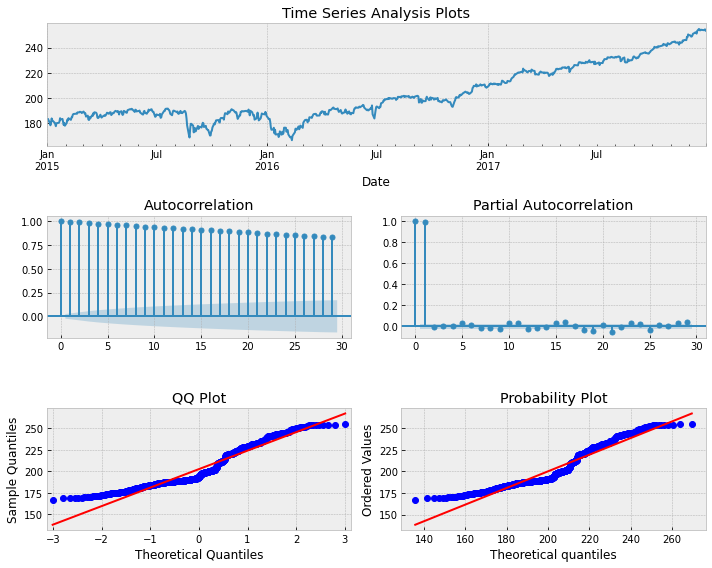

In [20]:
tsplot(spy_p)

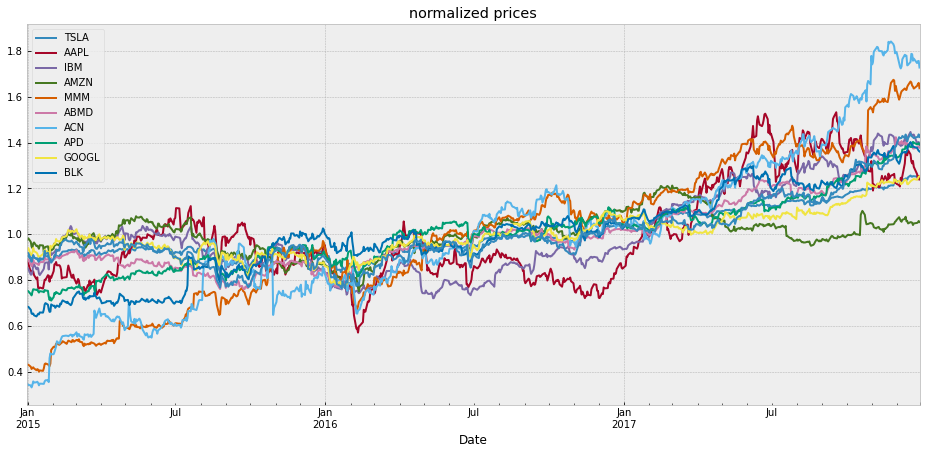

In [21]:
plt.figure(figsize=(16,7))
(spy_p / spy_p.mean()).plot()
for _, data in rp_df.iteritems():
    (data / data.mean()).plot()
plt.title("normalized prices")
plt.legend(tickers)
plt.show()

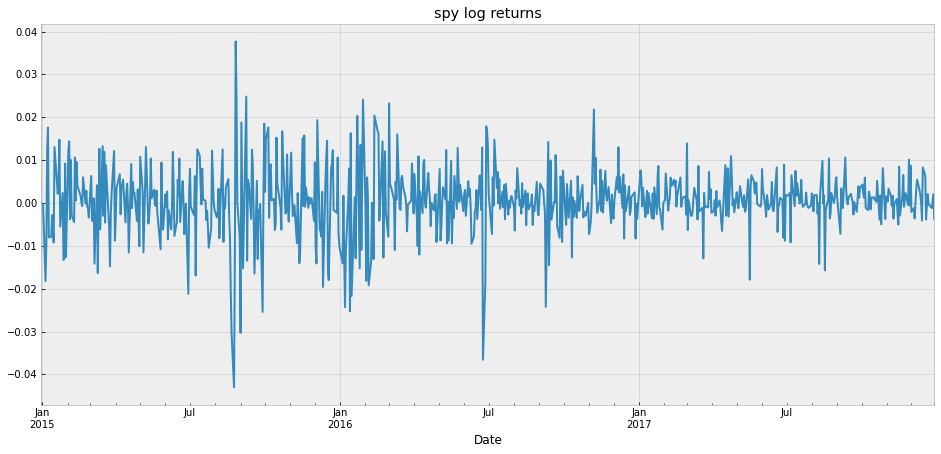

In [22]:
spy = raw_adj_close_log_returns(spy_p)
plt.figure(figsize=(16,7))
spy.plot()
plt.title("spy log returns")
plt.show()

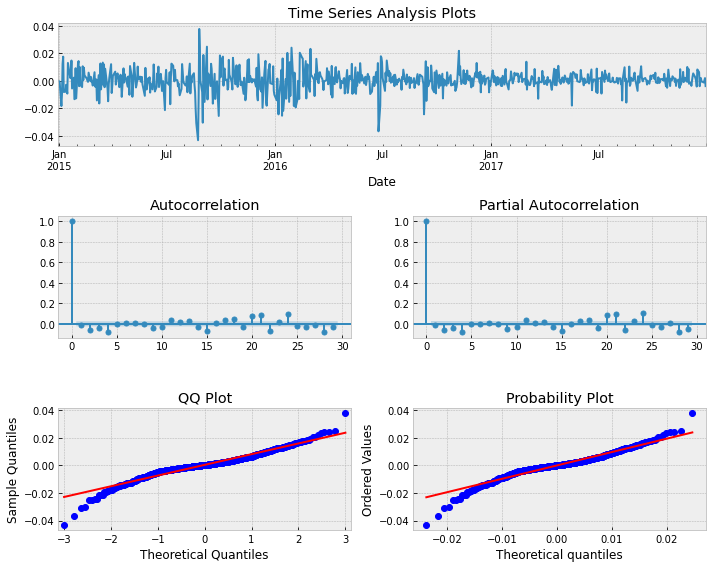

In [23]:
tsplot(spy)

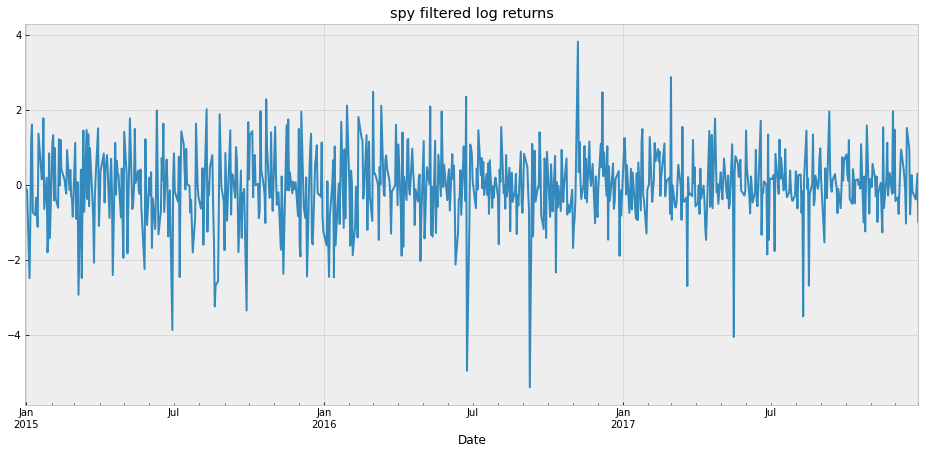

In [24]:
spyf, spy_means, spy_vars = arch_filtered_series(spy, lag=GARCH_LAG, forecast_horizon=GARCH_REFIT_DELAY_DAYS,
                                                mean=MEAN_MODEL, vol=VOL_MODEL, dist=DISTRIBUTION_,
                                                p=p_, o=o_, q=q_)
plt.figure(figsize=(16,7))
spyf.plot()
plt.title("spy filtered log returns")
plt.show()

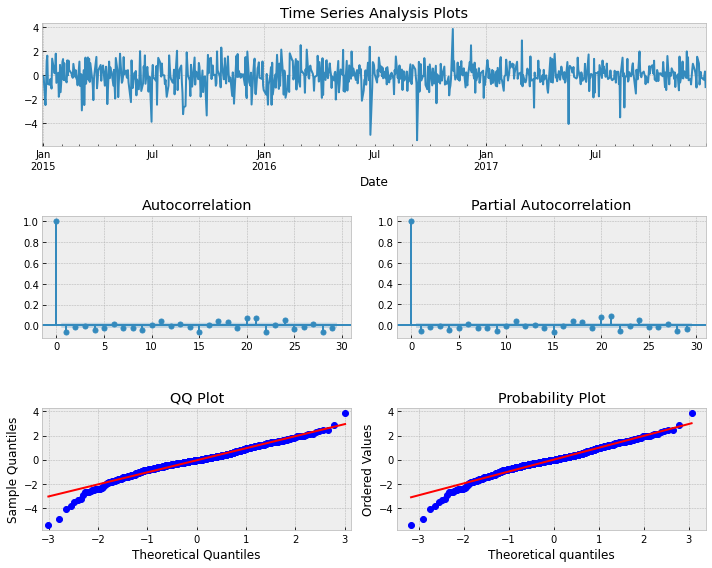

In [25]:
tsplot(spyf)

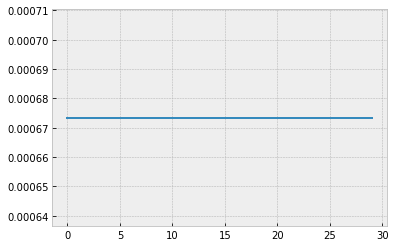

In [26]:
spy_means.plot()
plt.show()

In [27]:
res = spy_p.values
result = adfuller(res)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
res = spy.values
result = adfuller(res)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
res = spyf.dropna().values
result = adfuller(res)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.354182
p-value: 0.979698
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
ADF Statistic: -15.920028
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
ADF Statistic: -29.103844
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [28]:
mkt_returns = {}
for ticker, data in rp_df.iteritems():
    mkt_returns[ticker] = raw_adj_close_log_returns(data)

In [29]:
# %%time
# aics = {}
# pars = {}
# aic, params = _find_best_model_params(spy)
# aics['SPY'] = aic
# pars['SPY'] = params

In [30]:
# for ticker in tickers:
#    aic, params = _find_best_model_params(mkt_returns[ticker])
#    aics[ticker] = aic
#    pars[ticker] = params

In [31]:
%%time
betas = {}
if BETA_TYPE == BetaType.NO:
    for ticker in tickers:
        betas[ticker] = 0
elif BETA_TYPE == BetaType.RAW:
    for ticker, data in raw_prices.items():
        betas[ticker] = beta(spy_p, data, lag=BETA_LAG)
elif BETA_TYPE == BetaType.RETURNS:
    for ticker, data in mkt_returns.items():
        betas[ticker] = beta(spy, data, lag=BETA_LAG)
elif BETA_TYPE == BetaType.FILTERED:
    filtered_returns = {}
    for ticker, net_rets in mkt_returns.items():
        fltr_res, _, _ = arch_filtered_series(net_rets, lag=GARCH_LAG, forecast_horizon=GARCH_REFIT_DELAY_DAYS,
                                              mean=MEAN_MODEL, vol=VOL_MODEL, dist=DISTRIBUTION_, 
                                              p=p_, o=o_, q=q_)
        filtered_returns[ticker] = fltr_res[GARCH_LAG:]
    for ticker, data in filtered_returns.items():
        betas[ticker] = beta(spyf, data, lag=BETA_LAG)
betas

Wall time: 934 ms


{'TSLA': 0.2702278707225945,
 'AAPL': 0.40745667378163924,
 'IBM': 0.3677767528235974,
 'AMZN': 0.36144054996043873,
 'MMM': 0.41589245111439554,
 'ABMD': 0.31818175593872605,
 'ACN': 0.46506270299431024,
 'APD': 0.45425300950494885,
 'GOOGL': 0.4440765494044963,
 'BLK': 0.5880453287848227}

In [32]:
net_market_returns = {}
for ticker, data in mkt_returns.items():
    net_market_returns[ticker] = data - spy * betas[ticker]
    
nmkt_rets_df = pd.DataFrame(net_market_returns, columns=tickers)
nmkt_rets_df



,TSLA,AAPL,IBM,AMZN,MMM,ABMD,ACN,APD,GOOGL,BLK
Date,,,,,,,,,,
2014-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-01-02,-0.013892,-0.009340,0.010244,-0.005721,-0.001361,-0.019732,-0.005027,0.008529,-0.001856,-0.002009
2015-01-05,-0.038025,-0.021150,-0.009157,-0.014144,-0.015231,-0.000655,-0.008553,-0.024218,-0.011145,-0.015498
2015-01-06,0.008206,0.003950,-0.018321,-0.019677,-0.006785,-0.022673,-0.002838,0.003944,-0.020787,-0.010096
2015-01-07,-0.004910,0.008879,-0.011111,0.006068,0.002072,0.027393,0.015013,0.005117,-0.008445,0.013660
...,...,...,...,...,...,...,...,...,...,...
2017-12-22,-0.019599,0.000107,0.006675,-0.005368,-0.000104,0.005367,-0.001891,0.001711,-0.001744,-0.002713
2017-12-26,-0.024301,-0.025209,0.002602,0.007597,0.003561,-0.010638,-0.005309,-0.002030,-0.002288,0.003823
2017-12-27,-0.018099,-0.000022,0.001782,0.004487,0.002978,0.004477,0.001928,0.003881,-0.005531,0.000881


In [33]:
%%time
today = 2 * GARCH_LAG + 1
nmkt_retsf_df, means_df, vars_df = get_filtered_data(nmkt_rets_df[(today - 2 * GARCH_LAG - 1): today])#fixme check

Wall time: 805 ms


In [34]:
corr_matrix = nmkt_retsf_df.corr(min_periods=CORRELATION_MATRIX_LAG)

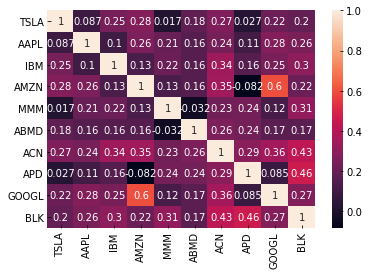

In [35]:
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [63]:
def trade(alphas, positions, prices, i):
    new_positions = pd.DataFrame({}, columns=tickers, index=[0])
    cash = positions.iloc[0]['CASH']
    if cash < 0:
        print("Negative cash! Bankrupt! ", cash, " @ ", i)
        print(alphas)
        print('=======================================================')
        print(positions)
        print('=======================================================')
        print(prices)
    pv = cash
    for ticker in tickers:
        pv = pv + positions.iloc[0][ticker] * prices[ticker]
    expected_positions = alphas.iloc[0] * pv
    max_pos = pv * MAX_POSITION_PER_EQUITY
    max_trade = pv * MAX_POSITION_PER_EQUITY_PER_TRADE
    for ticker in tickers:
        expected_positions[ticker] = min(expected_positions[ticker], max_pos)
    for ticker in tickers:
        amount_to_buy = expected_positions[ticker] - positions.iloc[0][ticker] * prices[ticker]
        if abs(amount_to_buy) > max_trade:
            amount_to_buy = math.copysign(max_trade, amount_to_buy)
        cash = cash - amount_to_buy - abs(amount_to_buy) * FEE
        new_positions[ticker] = positions.iloc[0][ticker] + amount_to_buy / prices[ticker]
    new_positions['CASH'] = cash    
    return pv, new_positions
    

In [37]:
init_positions = {}
for ticker in tickers:
    init_positions[ticker] = 0
init_positions['CASH'] = INITIAL_CASH
positions = pd.DataFrame(init_positions, index=[0])

In [61]:
%%time
pv_series = [INITIAL_CASH]
last_refit_date = GARCH_LAG * 2 + 1
alphas_s = pd.DataFrame()
flag = True
while last_refit_date < len(rp_df):
    nmkt_retsf_df, means_df, vars_df = get_filtered_data(nmkt_rets_df[: last_refit_date])#fixme check
    corr_matrix = nmkt_retsf_df.corr(min_periods=CORRELATION_MATRIX_LAG)
    for offset in range(0, GARCH_REFIT_DELAY_DAYS):
        today = min(last_refit_date + offset + 1, len(nmkt_rets_df) - 1)
        alphas = calc_alphas(nmkt_rets_df.iloc[today], corr_matrix, means_df.iloc[offset], vars_df.iloc[offset])
        normalized_alphas = (alphas / alphas.to_numpy().sum())
        if flag:
            print(normalized_alphas)
            flag = False
        pv, new_positions = trade(normalized_alphas, positions.tail(1), nmkt_rets_df.iloc[today], today)
        pv_series.append(pv)
        positions = positions.append(new_positions, ignore_index=True)
    last_refit_date = last_refit_date + GARCH_REFIT_DELAY_DAYS
    


       TSLA      AAPL       IBM      AMZN     MMM     ABMD       ACN  \
0  0.378557  0.041764  0.029352  0.289005  0.0476  0.14547  0.068704   

        APD     GOOGL       BLK  
0  0.119648  0.004878 -0.124978  
Negative cash! Bankrupt!  -4.900041344219756e+205  @  405
Negative cash! Bankrupt!  -3.569870840081666e+207  @  414
Negative cash! Bankrupt!  -3.09234337024674e+211  @  436
Negative cash! Bankrupt!  -2.3626800682061427e+212  @  437
Negative cash! Bankrupt!  -3.6749043094612206e+213  @  447
Negative cash! Bankrupt!  -1.5610451611331974e+214  @  448
Negative cash! Bankrupt!  -2.7879385890776236e+222  @  469
Negative cash! Bankrupt!  -7.69949253427031e+223  @  475
Negative cash! Bankrupt!  -5.639402723549161e+224  @  476
Negative cash! Bankrupt!  -4.9198983594998635e+224  @  477
Negative cash! Bankrupt!  -1.8003966510501286e+225  @  478
Negative cash! Bankrupt!  -5.0151332006351335e+228  @  486
Negative cash! Bankrupt!  -2.835802869410015e+232  @  499
Negative cash! Bankrupt!  -3

In [46]:
positions

,TSLA,AAPL,IBM,AMZN,MMM,ABMD,ACN,APD,GOOGL,BLK,CASH
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+05
1,-1.059442e+07,1.773597e+06,1.630190e+06,1.288417e+07,2.713048e+07,-4.100985e+06,8.570471e+06,-2.181556e+07,2.886220e+05,-2.754366e+06,2.535047e+05
2,-7.736012e+06,7.432208e+06,-3.166016e+08,6.228664e+07,5.337184e+07,1.719667e+08,3.272025e+06,-1.363675e+07,-4.442715e+06,2.368218e+06,1.137837e+05
3,3.109805e+07,1.365771e+08,-1.940768e+08,3.005257e+08,-1.008826e+08,1.523035e+08,5.719280e+07,2.308434e+08,1.146088e+08,5.482970e+07,-7.930102e+05
4,4.471219e+07,1.669490e+08,-1.246194e+08,1.397898e+08,-1.579653e+08,4.575328e+07,1.001450e+07,-6.831137e+07,3.110992e+07,9.791469e+07,7.751724e+05
...,...,...,...,...,...,...,...,...,...,...,...
356,-4.625092e+106,7.474887e+106,-3.607663e+106,-4.270353e+106,1.075904e+108,-1.326839e+107,-2.538004e+106,1.291321e+107,-7.358613e+107,9.979076e+106,-4.208120e+104
357,-4.624350e+106,7.621412e+106,-3.611046e+106,-4.269667e+106,1.082663e+108,-1.150188e+107,-2.225005e+106,1.291113e+107,-7.357432e+107,1.011413e+107,-1.229839e+104
358,-4.623841e+106,7.238228e+106,-3.321721e+106,-4.269198e+106,9.954959e+107,-9.735558e+106,-1.963260e+106,1.290971e+107,-7.356623e+107,9.491856e+106,9.436786e+103
359,-4.623222e+106,7.350230e+106,-3.313785e+106,-4.268626e+106,9.982664e+107,-7.969476e+106,-1.693169e+106,1.290798e+107,-7.355638e+107,9.586753e+106,3.864735e+104


<AxesSubplot:xlabel='Date'>

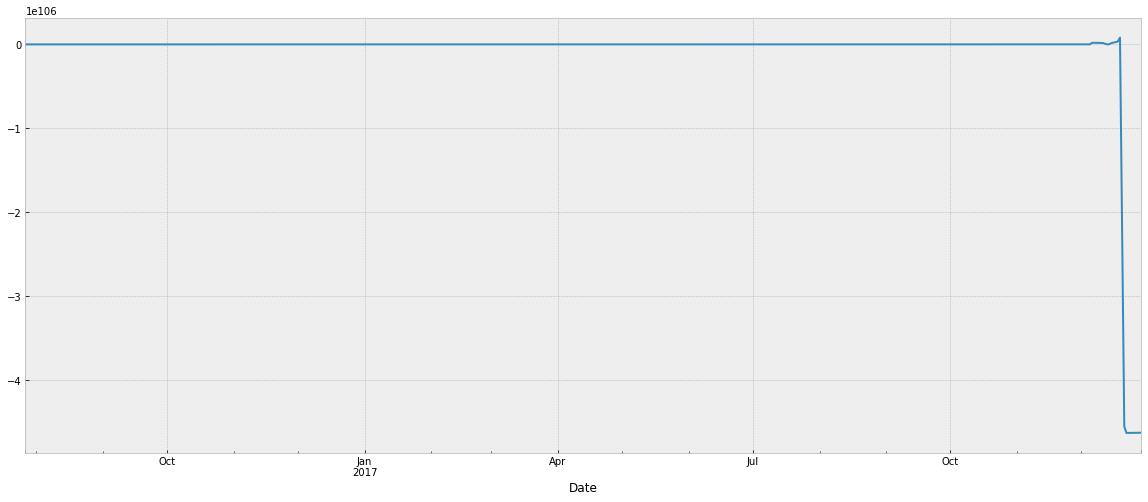

In [48]:
positions.index = spy_p.index[-len(positions):]
plt.figure(figsize=(20, 8))
positions['TSLA'].plot()

<AxesSubplot:xlabel='Date'>

<Figure size 1440x576 with 0 Axes>

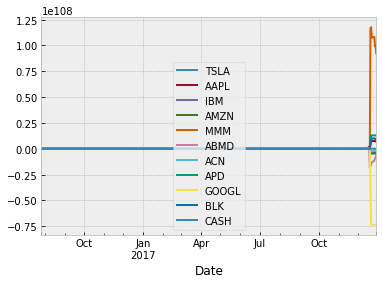

In [49]:
plt.figure(figsize=(20, 8))
positions.plot()

<AxesSubplot:xlabel='Date'>

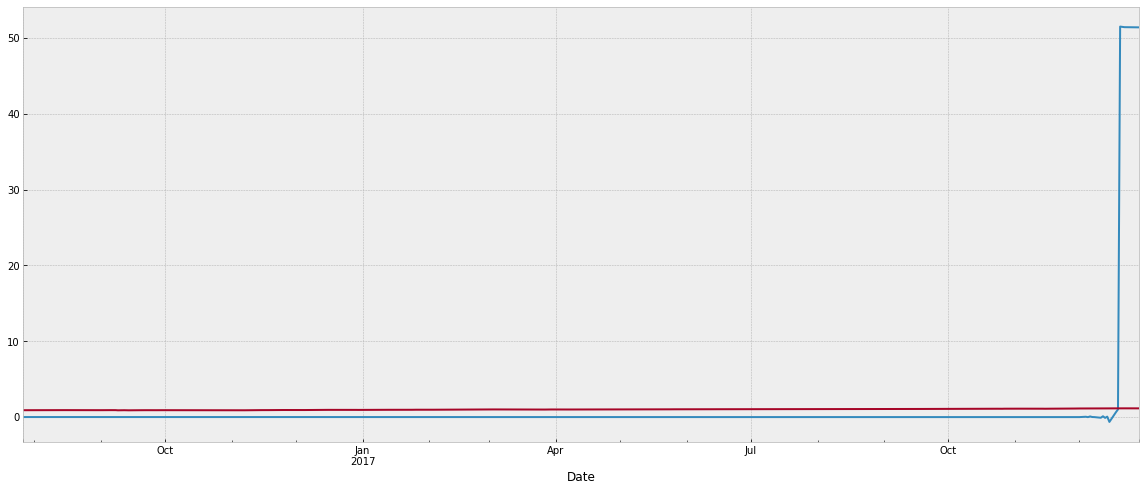

In [50]:
pv_s = pd.Series(pv_series)
pv_s.index = spy_p.index[-len(positions):]
plt.figure(figsize=(20, 8))
(pv_s / pv_s.mean()).plot()
(spy_p[-len(positions):] / spy_p[-len(positions):].mean()).plot()

In [51]:
pv_s[210:250]

Date
2017-05-26    6.189864e+65
2017-05-30   -1.280771e+65
2017-05-31    2.194114e+66
2017-06-01    3.372442e+68
2017-06-02    1.420014e+68
2017-06-05    3.069917e+67
2017-06-06   -1.433888e+68
2017-06-07    5.899642e+67
2017-06-08    2.631908e+68
2017-06-09   -4.769478e+68
2017-06-12    1.021294e+69
2017-06-13   -5.551690e+69
2017-06-14    1.003124e+70
2017-06-15   -1.266741e+70
2017-06-16    6.118384e+70
2017-06-19    1.198754e+70
2017-06-20    5.568543e+70
2017-06-21   -2.984844e+71
2017-06-22    2.748996e+71
2017-06-23    2.926283e+71
2017-06-26   -1.226938e+72
2017-06-27   -2.273887e+73
2017-06-28    7.012457e+73
2017-06-29    7.783402e+73
2017-06-30    3.686656e+73
2017-07-03    5.072054e+73
2017-07-05   -2.832927e+73
2017-07-06   -1.125568e+73
2017-07-07   -1.837257e+73
2017-07-10    2.088796e+73
2017-07-11   -1.026573e+74
2017-07-12   -9.079324e+73
2017-07-13    1.542724e+74
2017-07-14    9.673708e+74
2017-07-17    2.294629e+74
2017-07-18    3.706258e+76
2017-07-19   -6.199387e

<AxesSubplot:xlabel='Date'>

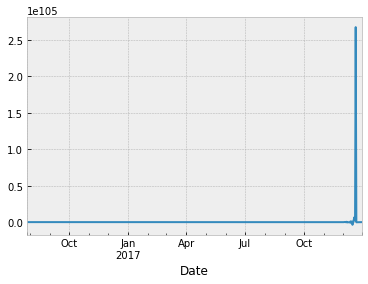

In [52]:
pnl = pv_s.diff()
pnl.plot()

In [53]:
pnl.min() / INITIAL_CASH

-7.406506456988809e+97

In [54]:
beta(spy[-len(pnl):], pnl)

-1.0303755471079021e+102

In [55]:
beta(spy_p[-len(pv_s):], pv_s)

5.846764305893866e+103

In [56]:
pnl.mean() / pnl.std()

0.05362668982631437

In [57]:
alphas_s

""
